# Model Training

The first two tutorials provided us with all the tools we need to build and train simple Machine Learning models. We'll see how to do this through a couple of case studies.

First, let's generate a toy dataset to train and evaluate our models on. If you're unfamiliar with any of the concepts involving ML you can check out these two tutorials: [[1]](https://github.com/djib2011/python_ml_tutorial/blob/master/notebooks/19_intro_to_machine_leaning.ipynb), [[2]](https://github.com/djib2011/python_ml_tutorial/blob/master/notebooks/20_scikit-learn.ipynb).

In [0]:
!pip install --upgrade tensorflow
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


Text(0.5, 1.0, 'Full dataset')

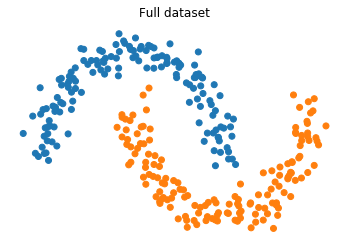

In [0]:
np.random.seed(13)

X, y = make_moons(300, noise=0.1)

######################################################################
############################## PLOTTING ##############################
######################################################################

colors = ['C' + str(i) for i in y]
ax = plt.subplot(111)
ax.scatter(X[:, 0], X[:, 1], c=colors)
ax.axis('off')
ax.set_title('Full dataset')

Now, let's split the data into a training and a test set.


Text(0.5, 1.0, 'Test set')

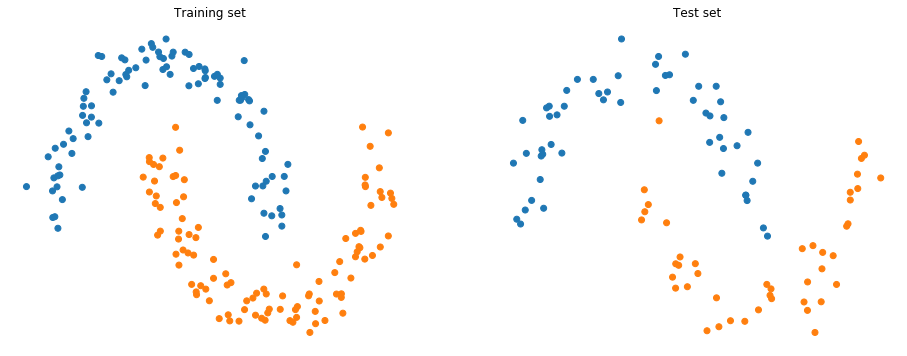

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

######################################################################
############################## PLOTTING ##############################
######################################################################
plt.figure(figsize=(16, 6))

ax = plt.subplot(121)
colors = ['C' + str(i) for i in y_train]
ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)
ax.axis('off')
ax.set_title('Training set')

ax = plt.subplot(122)
colors = ['C' + str(i) for i in y_test]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)
ax.axis('off')
ax.set_title('Test set')

## Case Study 1: Logistic Regression

We'll now attempt to build a logistic regressor in TensorFlow. This model essentially performs the operation:

$$
\hat y = \sigma (X \cdot W + b)
$$

where $\hat y$ are the model's predictions, $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), $W$ is a matrix of parameters, referred to as *weights*, $X$ are the inputs and $b$ are another set of parameters called *biases*.


In [0]:
# Convert data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Model parameters
# It's a good practice to store parameters into tf.Variables instead of 
# tf.Tensors. One added benefit is that we won't have to watch them
# explicitly in tf.GradientTape's context.)

tf.random.set_seed(5)
W = tf.Variable(tf.random.normal(shape=(2, 1)))  # we'll set random values for W
b = tf.Variable(tf.zeros(shape=(1, 1)))          # and zeros for b

# Generate a prediction
y_hat = tf.math.sigmoid(tf.matmul(X_train, W) + b)
y_hat[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.42412487],
       [0.28484544],
       [0.35144103],
       [0.2737902 ],
       [0.27891627],
       [0.2810163 ],
       [0.5431805 ],
       [0.5617515 ],
       [0.5766216 ],
       [0.5508079 ]], dtype=float32)>

Before proceeding we'll need a way to measure how well the predictions are. To do this we'll define a [**loss function**](https://en.wikipedia.org/wiki/Loss_function) (also referred to as *cost function*), which increases the farther away our predictions are from the actual labels (i.e. $y$). A loss of $0$ means that the predictions are spot on.

The simplest loss function we can use is the **Mean-Squared Error (MSE)**:

$$
J(y, \hat y) = MSE(y, \hat y) = \frac{1}{N}\sum_{i=1}^N{(y - \hat y)^2}
$$

where $N$ is the number of samples in the sets $y$ and $\hat y$.

In [0]:
def mse(y, y_hat):
  N = y.shape[0]
  return tf.math.reduce_sum((y - y_hat)**2) / N

mse(y_train, y_hat)

<tf.Tensor: shape=(), dtype=float32, numpy=54.27715>

The predictions at this point are random, because the model hasn't been trained yet. To train the model, we'll use an optimization technique called [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent). The idea is to compute the partial derivative of the loss w.r.t the model's parameters (in this case $W$ and $b$) and to update them according to that derivative.

$$
W \leftarrow W - \lambda \frac{\partial J}{\partial W} \\
b \leftarrow b - \lambda \frac{\partial J}{\partial b}
$$

Note that the partial derivative of $J$ w.r.t $W$ shows the *direction* that W needs to be changed to increase the loss the most. The opposite (i.e. $- \partial J / \partial W$), shows how to decrease the loss the most. That's why we want to update our parameters in that direction. 

The other term, $\lambda$, is called a **learning rate** and designates how *large steps* we are doing during optimization. This is very important to figure out correctly as small learning rates will cause the optimization to be very slow, while very large steps might cause it to never converge to the optimum. Parameters like these that need to be tuned manually are called **hyperparameters**. 





In [0]:
lr = 0.01  # learning rate

def predict(x):
  '''
  function to generate predictions for convenience
  '''
  return tf.math.sigmoid(tf.matmul(x, W) + b)

with tf.GradientTape() as tape:
  y_hat = predict(X_train)
  loss = mse(y_train, y_hat) 

dw, db = tape.gradient(loss, [W, b])  # partial derivatives w.r.t W and b

W.assign_sub(lr * dw)  # if we write W = W - lr * dw, W will become a tf.Tensor
b.assign_sub(lr * db)  # this is done as a preference so that we stick with
                       # tf.Variables as our data types for parameters

new_loss = mse(y_train, predict(X_train))

print('Old loss:', loss.numpy())
print('New loss:', new_loss.numpy())

Old loss: 54.27715
New loss: 53.163464


The loss decreased, so we're making better predictions. The loss by itself, though, isn't very intuitive, so we'll compute the **accuracy** of our predictions, i.e. what percentage did we get right.

The predictions however are continuous, in the range $[0, 1]$ due to the sigmoid. These can be thought of as the *confidence* of the model, i.e. how confident it is that a given sample belongs to class $1$. To make them discrete, we'll set a threshold at $0.5$ and treat any predictions above as class $1$ and any predictions below as class $0$.

Accuracy = 72.64%


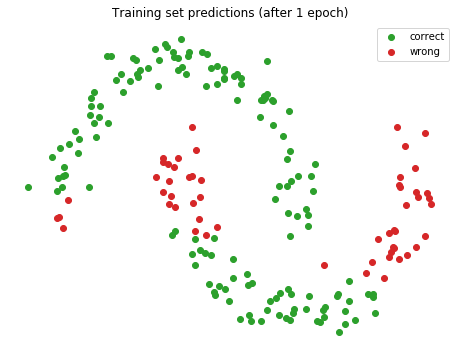

In [0]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

binary_predictions = (y_hat > 0.5).numpy().astype(int).flatten()

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(8, 6))

ax = plt.subplot(111)

results = y_train == binary_predictions
colors = ['C2'  if p else 'C3' for p in results]

correct = X_train[results]
wrong = X_train[~results]

ax.scatter(correct[:, 0], correct[:, 1], c='C2', label='correct')
ax.scatter(wrong[:, 0], wrong[:, 1], c='C3', label='wrong')
ax.axis('off')
ax.legend()
ax.set_title('Training set predictions (after 1 epoch)')


print('Accuracy = {:.2f}%'.format(accuracy(y_train, binary_predictions)*100))

The model isn't very good at this point, but Gradient Descent is an iterative process. It requires multiple iterations to converge. In the context of Machine Learning, every pass over the whole training set (like we did before) is called an **epoch**. 

Let's now define our training loop to train a model over multiple epochs.

Text(0.5, 1.0, 'Loss progression during training')

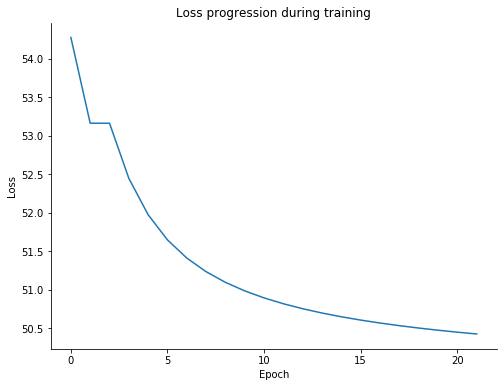

In [0]:
training_losses = [loss, new_loss]  # we'll store the loss for each epoch to see
                                    # if the model converges
epochs = 20  # we'll train for 10 epochs

for e in range(epochs):

  with tf.GradientTape() as tape:
    y_hat = predict(X_train)
    loss = mse(y_train, y_hat) 

  dw, db = tape.gradient(loss, [W, b]) 

  W.assign_sub(lr * dw)
  b.assign_sub(lr * db)

  training_losses.append(loss)

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(8, 6))

ax = plt.subplot(111)

ax.plot(training_losses)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss progression during training')

This is a normal-looking loss curve. It starts as a high value and drops asymptotically as training progresses. 

Let's see how the model now predicts.

Accuracy = 69.15%


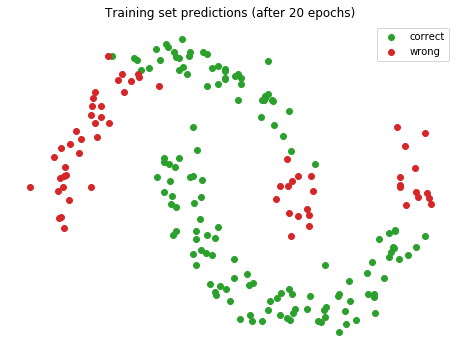

In [0]:
# Generate the final predictions and convert them to binary
y_hat = predict(X_train)  
binary_predictions = (y_hat > 0.5).numpy().astype(int).flatten()

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(8, 6))

ax = plt.subplot(111)

results = y_train == binary_predictions
colors = ['C2'  if p else 'C3' for p in results]

correct = X_train[results]
wrong = X_train[~results]

ax.scatter(correct[:, 0], correct[:, 1], c='C2', label='correct')
ax.scatter(wrong[:, 0], wrong[:, 1], c='C3', label='wrong')
ax.axis('off')
ax.legend()
ax.set_title('Training set predictions (after 20 epochs)')

print('Accuracy = {:.2f}%'.format(accuracy(y_train, binary_predictions)*100))

As we can see the model still makes its fair share of mistakes. A better way to visualize this would be to draw the decision boundaries on the graph. For this we will base our visualization on [this example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

Text(0.5, 1.0, 'Training set samples and predictions')

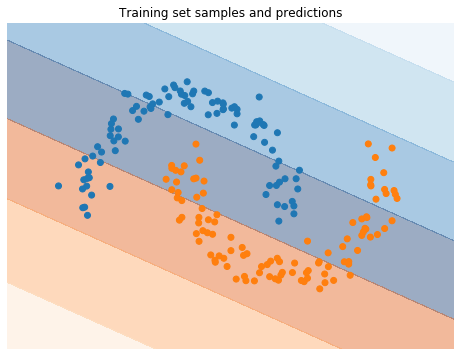

In [0]:
######################################################################
############################## PLOTTING ##############################
######################################################################

# Find out where to start and end the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Generate the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05, dtype=np.float32),
                     np.arange(y_min, y_max, 0.05, dtype=np.float32))

# Generate predictions for each point of the mesh
mesh_preds = predict(np.c_[xx.ravel(), yy.ravel()]).numpy()

# We'll also create a custom diverging colormap from blue to orange. 
# Details here:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html 

blue = matplotlib.cm.get_cmap('Blues', 128)
orange = matplotlib.cm.get_cmap('Oranges_r', 128)

color_array = np.vstack((blue(np.linspace(0, 1, 128)),
                         orange(np.linspace(0, 1, 128))))

BuOr = matplotlib.colors.ListedColormap(color_array)

# Create the figure
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

# Draw the mesh predictions as contours
ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

# Draw the data points in their actual colors
colors = ['C' + str(int(i)) for i in y_train]
ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)

ax.axis('off')
ax.set_title('Training set samples and predictions')

The dots are the training examples and their colors represent the actual labels. The contours on the background show the model's predictions. If a blue dot is placed on a blue area then it is correctly classified, while if it is in an orange area it is a missclassification.

Note that the decision boundary is a straight line and that's why there are a lot of missclassifications.

Finally, let's see how we did on the test set.

Accuracy = 56.57%


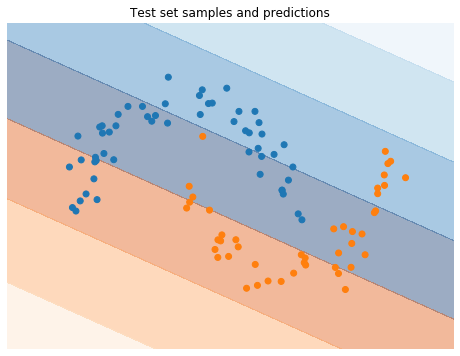

In [0]:
y_hat = predict(X_test)  
binary_predictions = (y_hat > 0.5).numpy().astype(int).flatten()

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

colors = ['C' + str(int(i)) for i in y_test]
ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)

ax.axis('off')
ax.set_title('Test set samples and predictions')

print('Accuracy = {:.2f}%'.format(accuracy(y_test, binary_predictions)*100))

As expected, we did even worse on the test set. There's not much more we can with the simple logistic regression classifier to improve its performance, because it doesn't have the **capacity** to learn nore complex relationships than linear.

## Case Study 2: Multi-Layer Perceptron

The second case study we'll examine is a Multi-Layer Perceptron (MLP). This is a Fully-Connected Neural Network that has one or more hidden layers. 

We'll just attempt to create a simple one with $1$ hidden layer with $10$ neurons. 




In [0]:
tf.random.set_seed(6)

# Hidden layer parameters
W_h = tf.Variable(tf.random.normal(shape=(2, 10)))  # shape=(input_features, hidden_layer_neurons)
b_h = tf.Variable(tf.random.normal(shape=(1, 10)))

# Output layer parameters
W_o = tf.Variable(tf.random.normal(shape=(10, 1)))  # shape=(hidden_layer_neurons, output)
b_o = tf.Variable(tf.random.normal(shape=(1, 1)))

# Create a list of all of the model's trainable parameters
trainable_params = [W_h, b_h, W_o, b_o]

# Hidden layer operations
def hidden(x):
  return tf.math.sigmoid(tf.matmul(x, W_h) + b_h)

# Output layer operations
def output(x):
  return tf.math.sigmoid(tf.matmul(x, W_o) + b_o)

# Rewrite accuracy function so that it takes the model's predictions as they are
def accuracy(y_true, y_pred):
  bin_preds = (y_pred > 0.5).numpy().astype(int).flatten()
  return np.sum(y_true == bin_preds) / len(y_true) 

# Run predictions for random weights
hidden_layer_outputs = hidden(X_train)
y_hat = output(hidden_layer_outputs)
loss = mse(y_train, y_hat)
acc = accuracy(y_train, y_hat)
print('Initial loss:', loss)
print('Initial accuracy: {:.2f}%'.format(acc*100))

Initial loss: tf.Tensor(65.236824, shape=(), dtype=float32)
Initial accuracy: 47.76%


One thing to note is that both layers essentially do the same thing: an affine transformation (i.e. $z = X\cdot W + b$), followed by a sigmoid function (i.e. $\sigma(z)$). This sigmoid function allows the network to approximate non-linear relationships between the input features and their labels. A sigmoid is not the only choice for a non-linear function, other popular choices are [tanh](http://mathworld.wolfram.com/HyperbolicTangent.html), [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) and [softmax](https://en.wikipedia.org/wiki/Softmax_function) (we'll see more details in a later tutorial). Non-linear functions like these that follow the affine transformation of a layer's inputs are called **activation functions**.

To make our life easier we'll define two functions to assist us during training and prediction. These two will perform the **forward** and **backward passes** for our network. The forward pass is the procedure that generates the prediction out of an input (i.e. the whole series of transformations from the beginning to the end of the network). The backward pass is the computation of the gradients of the loss w.r.t each one of the model's parameters.

In [0]:
def forward(x):
  '''
  Gererate the prediction for an input tensor x
  '''
  return output(hidden(x))

def backward(x, y):
  '''
  Compute the gradients for the loss w.r.t the model's trainable parameters,
  for an input tensor x
  '''
  with tf.GradientTape() as tape:
    y_hat = forward(x)
    loss = mse(y, y_hat)
  return tape.gradient(loss, trainable_params), loss

The latter is takes its name from the algorithm used to compute the gradients, which is called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation). 

It is a common misconception that backpropagation handles the parapeter updates, but that isn't the case; the algorithm is meant to compute the gradients efficiently. To handle with the actual optimization we have another algorithm, in this case Gradient Descent; these algorithms are referred to as **optimizers**. We'll write a function to handle the parameter updates.

In [0]:
def gd_update(gradients):
  '''
  Apply a single step of Gradient Descent to the model's trainable parameters.
  '''
  for p, g in zip(trainable_params, gradients):
    p.assign_sub(lr * g)

Now, we have all we need to train the MLP.

In [0]:
lr = 0.01
epochs = 20
training_losses = [loss]

for e in range(epochs):
  grads, loss = backward(X_train, y_train)
  gd_update(grads)
  training_losses.append(loss)

print('Training accuracy: {:.2f}%'.format(accuracy(y_train, forward(X_train))*100))
print('Test accuracy: {:.2f}%'.format(accuracy(y_test, forward(X_test))*100))

Training accuracy: 56.72%
Test accuracy: 48.48%


Text(0.5, 1.0, 'Loss progression during training')

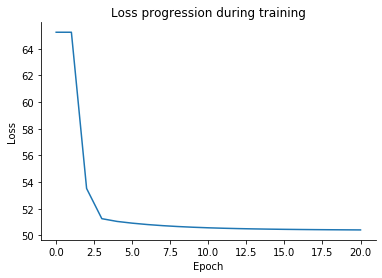

In [0]:
######################################################################
############################## PLOTTING ##############################
######################################################################

ax = plt.subplot(111)
ax.plot(training_losses)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss progression during training')

We can see that the model sort-of trained, however it still isn't doing very well. At this point it should be noted that **Neural Networks are hard to train**. There are many hyperparameters involved (number of hidden layers, neurons per hidden layer, etc.) and the Gradient Descent optimizer can get too often stuck in local-minima situations like above.

Let's see if we can do better with a smaller network.

Training accuracy: 76.12%
Test accuracy: 77.78%


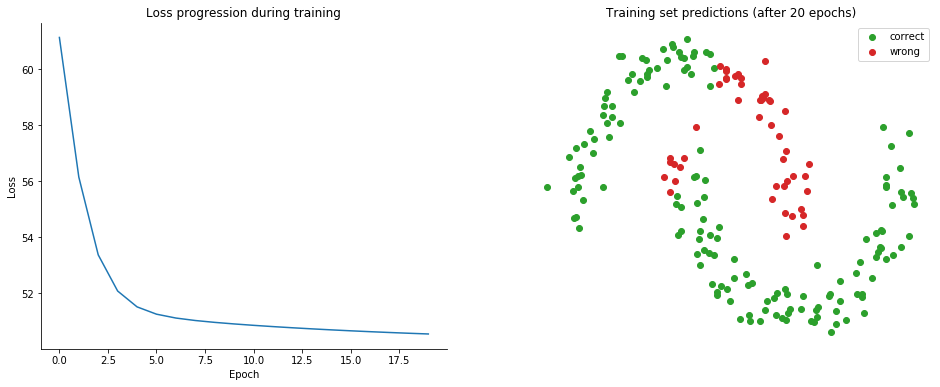

In [0]:
tf.random.set_seed(6)
training_losses = []

# Hidden layer parameters
W_h = tf.Variable(tf.random.normal(shape=(2, 3)))  # shape=(input_features, hidden_layer_neurons)
b_h = tf.Variable(tf.zeros(shape=(1, 3)))

# Output layer parameters
W_o = tf.Variable(tf.random.normal(shape=(3, 1)))  # shape=(hidden_layer_neurons, output)
b_o = tf.Variable(tf.zeros(shape=(1, 1)))

# Create a list of all of the model's trainable parameters
trainable_params = [W_h, b_h, W_o, b_o]

for e in range(epochs):
  grads, loss = backward(X_train, y_train)
  gd_update(grads)
  training_losses.append(loss)

######################################################################
############################## PLOTTING ##############################
######################################################################

plt.figure(figsize=(16, 6))

ax = plt.subplot(121)

ax.plot(training_losses)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss progression during training')

ax = plt.subplot(122)

results = y_train == (forward(X_train) > 0.5).numpy().astype(int).flatten()
colors = ['C2'  if p else 'C3' for p in results]

correct = X_train[results]
wrong = X_train[~results]

ax.scatter(correct[:, 0], correct[:, 1], c='C2', label='correct')
ax.scatter(wrong[:, 0], wrong[:, 1], c='C3', label='wrong')
ax.axis('off')
ax.legend()
ax.set_title('Training set predictions (after {} epochs)'.format(int(epochs)))

print('Training accuracy: {:.2f}%'.format(accuracy(y_train, forward(X_train))*100))
print('Test accuracy: {:.2f}%'.format(accuracy(y_test, forward(X_test))*100))

Text(0.5, 1.0, 'Training set samples and predictions')

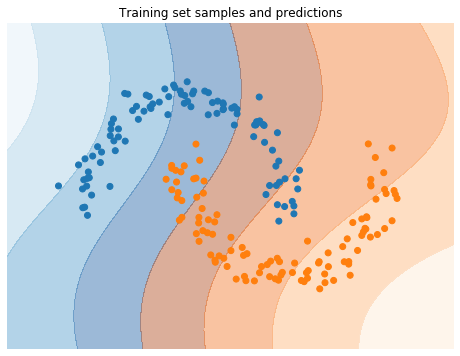

In [0]:
######################################################################
############################## PLOTTING ##############################
######################################################################

# Find out where to start and end the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Generate the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05, dtype=np.float32),
                     np.arange(y_min, y_max, 0.05, dtype=np.float32))

# Generate predictions for each point of the mesh
mesh_preds = forward(np.c_[xx.ravel(), yy.ravel()]).numpy()

# We'll also create a custom diverging colormap from blue to orange. 
# Details here:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html 

blue = matplotlib.cm.get_cmap('Blues', 128)
orange = matplotlib.cm.get_cmap('Oranges_r', 128)

color_array = np.vstack((blue(np.linspace(0, 1, 128)),
                         orange(np.linspace(0, 1, 128))))

BuOr = matplotlib.colors.ListedColormap(color_array)

# Create the figure
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

# Draw the mesh predictions as contours
ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

# Draw the data points in their actual colors
colors = ['C' + str(int(i)) for i in y_train]
ax.scatter(X_train[:, 0], X_train[:, 1], c=colors)

ax.axis('off')
ax.set_title('Training set samples and predictions')

Clearly a MLP has the capacity to learn non-linear relationships between the features and the labels, however it's very hard to come to an optimal solution (and we haven't even discussed overfitting!). Try to play a bit with the parameters and see if tou can improve the performance even more (e.g. try to use $45$ as a seed).

Fortunately, there are many techniques we can use to make our life easier and our Neural Networks more effective! In future tutorials we'll discuss different network architectures, more appropriate loss functions, better optimization algorithms, regularization techniques and many more. However, the next tutorial will focus on doing the same exact thing as we did here in a much more user-friendly manner, through the keras API.